# Variability analysis for HBEC IFN experiment

In [1]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.2-py3.7.egg')
import memento

In [3]:
data_path = '/data_volume/ifn_hbec/'

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [4]:
adata_processed = sc.read(data_path + 'HBEC_type_I_processed.h5ad')

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')
adata.obs.donor.value_counts()

d2513    34957
d2614    34295
Name: donor, dtype: int64

In [6]:
adata = adata[
    adata.obs.cell_type.isin(['club', 'basal/club']) & \
    adata.obs.stim.isin(['control','beta'])].copy()

/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


In [7]:
adata.obs.donor.value_counts()

d2614    6317
d2513    5482
Name: donor, dtype: int64

In [8]:
adata.shape

(11799, 36601)

### Perform 1D test to find genes that are generally upregulated

Use all time steps

In [9]:
time_converter={0:0, 3:1, 6:1, 9:1, 24:1, 48:1}
adata.obs['time_step'] = adata.obs['time'].astype(int).apply(lambda x: time_converter[x])

In [10]:
memento.create_groups(adata, label_columns=['time_step'], inplace=True, q=0.25*0.2)
memento.compute_size_factors(adata, trim_percent=0.05)
memento.compute_1d_moments(adata, inplace=True, filter_mean_thresh=0.2, min_perc_group=.9)

In [36]:
memento.ht_1d_moments(
    adata, 
    formula_like='1 + time_step',
    cov_column='time_step', 
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    2.7s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    8.1s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   15.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   25.7s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   39.1s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   56.3s
[Parallel(n_jobs=13)]: Done 2394 out of 2394 | elapsed:  1.3min finished


In [47]:
result_1d_overall = memento.get_1d_ht_result(adata)
result_1d_overall['de_fdr'] = memento.util._fdrcorrect(result_1d_overall['de_pval'])
de_genes = result_1d_overall.query('de_fdr < 0.05 & de_coef > 0 & ~gene.str.contains("MT-").values').gene.tolist()

In [64]:
result_1d_overall.query('gene == "HES4"')

,gene,de_coef,de_pval,dv_coef,dv_pval,de_fdr
0,HES4,0.749431,6.860194e-07,0.09733,0.213,0.000002


### Plot the progression for these DE genes

In [223]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [224]:
adata = adata[adata.obs.stim.isin(['control','alpha'])].copy()

In [225]:
time_converter={0:0, 3:1, 6:2, 9:3, 24:4, 48:5}
adata.obs['time_step'] = adata.obs['time'].astype(int).apply(lambda x: time_converter[x])

In [226]:
memento.create_groups(adata, label_columns=['time_step'], inplace=True, q=0.25*0.2)
memento.compute_size_factors(adata, trim_percent=0.05)
memento.compute_1d_moments(adata, inplace=True, filter_mean_thresh=0.2, min_perc_group=.9, filter_genes=False)

In [227]:
moments_mean, moments_var, _ = memento.get_1d_moments(adata)

In [228]:
def plot_time_expr(gene):
    
    plt.figure(figsize=(6,3));
    plt.subplot(1, 2, 1);
    plt.title('{} mean'.format(gene))
    plt.scatter(np.arange(6), moments_mean[moments_mean.columns.sort_values()].query('gene == "{}"'.format(gene)).iloc[0, 1:].values)
    plt.subplot(1, 2, 2);
    plt.title('{} variability'.format(gene))
    plt.scatter(np.arange(6), moments_var[moments_var.columns.sort_values()].query('gene == "{}"'.format(gene)).iloc[0, 1:].values)

<Figure size 432x216 with 0 Axes>

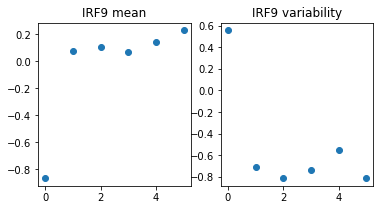

In [229]:
plt.figure(figsize=(6, 3));
plot_time_expr('IRF9');

<Figure size 432x216 with 0 Axes>

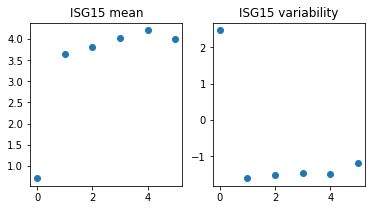

In [230]:
plt.figure(figsize=(6, 3));
plot_time_expr('ISG15');

<Figure size 432x216 with 0 Axes>

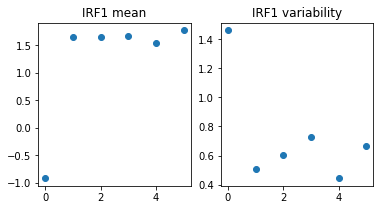

In [179]:
plt.figure(figsize=(6, 3));
plot_time_expr('IRF1');

In [58]:
moments_mean[moments_mean.columns.sort_values()].query('gene == "ISG15"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
1,ISG15,0.663902,3.565735,3.838548,3.959382,4.057398,3.786915


In [59]:
moments_var[moments_var.columns.sort_values()].query('gene == "ISG15"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
1,ISG15,2.423768,-0.288747,-0.020755,0.040945,-0.055663,0.185579


In [41]:
moments_mean[moments_mean.columns.sort_values()].query('gene == "SAT1"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
2313,SAT1,2.738188,3.175648,3.054841,3.314051,3.373495,3.202804


In [42]:
moments_var[moments_var.columns.sort_values()].query('gene == "SAT1"')

,gene,sg^0,sg^1,sg^2,sg^3,sg^4,sg^5
2313,SAT1,0.966216,-0.164159,0.026237,0.397797,0.051375,0.285033


In [67]:
adata.shape

(7406, 2576)

In [68]:
memento.ht_1d_moments(
    adata, 
    formula_like='1 + time_step',
    cov_column='time_step', 
    num_boot=10000, 
    verbose=1,
    num_cpus=13)

[Parallel(n_jobs=13)]: Using backend LokyBackend with 13 concurrent workers.
[Parallel(n_jobs=13)]: Done  24 tasks      | elapsed:    3.5s
[Parallel(n_jobs=13)]: Done 174 tasks      | elapsed:    8.4s
[Parallel(n_jobs=13)]: Done 424 tasks      | elapsed:   15.2s
[Parallel(n_jobs=13)]: Done 774 tasks      | elapsed:   25.1s
[Parallel(n_jobs=13)]: Done 1224 tasks      | elapsed:   38.5s
[Parallel(n_jobs=13)]: Done 1774 tasks      | elapsed:   55.0s
[Parallel(n_jobs=13)]: Done 2424 tasks      | elapsed:  1.3min
[Parallel(n_jobs=13)]: Done 2576 out of 2576 | elapsed:  1.4min finished


In [69]:
moments_1d = memento.get_1d_moments(adata)

In [70]:
moments_1d[1][moments_1d[1].columns.sort_values()].query('gene == "TXN"')

,gene,sg^0,sg^1
1197,TXN,-0.442353,0.22366


In [71]:
result_1d = memento.get_1d_ht_result(adata)


In [74]:
moments_1d[1].query('gene == "SAT1"')

,gene,sg^1,sg^0
2502,SAT1,-0.242884,0.523133


In [76]:
result_1d.query('gene == "SAT1"')

,gene,de_coef,de_pval,dv_coef,dv_pval
2502,SAT1,0.293283,2.999310e-07,-0.766018,1.016518e-12
